In [132]:
import numpy as np
import matplotlib.pyplot as plt

import importlib
import agent;importlib.reload(agent)
import blockworld;importlib.reload(blockworld)

from blockworld import Blockworld
from simple_spatial import SimpleSpatial
from agent import solve_using_ordered_goal_subset, bfs_search, solve_using_ordered_goal_subset_perf1

from collections import namedtuple

from tqdm import tqdm_notebook as tqdm

import random

In [2]:
def make_letters(start, number):
    '''Returns list of `number` letters, starting from `start`. Letters are generated in ASCII sequence.'''
    return [chr(ord(start) + i) for i in range(number)]

abc = make_letters('A', 3)
print(abc)
assert abc == ['A', 'B', 'C']
_def = make_letters('D', 3)
assert _def == ['D', 'E', 'F']

['A', 'B', 'C']


In [139]:
def generate_blockworld_problems(
    B=5,
    S=3,
    n_probs=100,
    seed=None,
):
    '''
    Generate blockworld problems.

    Each problem has the same number of letters B and spaces S.
    To generate, we randomly select a letter (without replacement)
    and place it at a random space.
    '''
    np.random.seed(seed)
    problems = []
    letters = make_letters('A', B)
    spaces = range(S)

    for _ in range(n_probs):
        # You have B letters and S spaces. Until all have been placed,
        # choose random letter without replacement to put at random space.
        initial = [() for _ in spaces]
        for letter in np.random.permutation(letters):
            space = np.random.choice(spaces)
            initial[space] += (letter,)

        initial = tuple(initial)

        problems.append(initial)

    return problems, letters

generated, letters = generate_blockworld_problems(seed=42, B=6)
print('Sample initial state', generated[0])

def _generate_standard_goals_for_blocks(initial, debug=True):
    letters = sorted([l for ls in initial for l in ls])
    goals = []
    for top, bottom in reversed(list(zip(letters[:-1], letters[1:]))):
        if debug:
            print('Goal {}: {} on top of {}'.format(len(goals), top, bottom))
        goals.append(Blockworld.make_above_predicate(top, bottom))
    goals_with_clearing = [Blockworld.make_is_bottom_of_column_predicate(letters[-1])]+goals
    return goals_with_clearing

goals_with_clearing = _generate_standard_goals_for_blocks(generated[0])

Sample initial state (('A', 'B'), ('C',), ('F', 'E', 'D'))
Goal 0: E on top of F
Goal 1: D on top of E
Goal 2: C on top of D
Goal 3: B on top of C
Goal 4: A on top of B


In [4]:
for initial in generated[:5]:
    problem = Blockworld(initial, goals_with_clearing)
    print('\nNew problem:', initial)
    print(problem.render(initial))
    print('optimal', len(bfs_search(problem)))
    for k in range(1, len(problem.goals)+1):
        print('considering k={}'.format(k), end='')
        results = [
            # returns history, solved
            solve_using_ordered_goal_subset(problem, k=k)
            for _ in range(3)
        ]
        if all(solved for history, solved in results):
            msg = 'All solved'
        elif any(solved for history, solved in results):
            msg = 'Some solved'
        else:
            msg = 'Could not be solved'
        print(' {}; # moves in {} trials'.format(msg, len(results)), [len(h) - 1 for h, _ in results])


New problem: (('A', 'B'), ('C',), ('F', 'E', 'D'))
...
...
...
..D
B.E
ACF

optimal 3
considering k=1 All solved; # moves in 3 trials [3, 3, 3]
considering k=2 All solved; # moves in 3 trials [3, 3, 3]
considering k=3 All solved; # moves in 3 trials [3, 3, 3]
considering k=4 All solved; # moves in 3 trials [3, 3, 3]
considering k=5 All solved; # moves in 3 trials [3, 3, 3]
considering k=6 All solved; # moves in 3 trials [3, 3, 3]

New problem: (('A',), ('B', 'D', 'F', 'C'), ('E',))
...
...
.C.
.F.
.D.
ABE

optimal 8
considering k=1 All solved; # moves in 3 trials [8, 12, 14]
considering k=2 All solved; # moves in 3 trials [8, 8, 8]
considering k=3 All solved; # moves in 3 trials [8, 8, 8]
considering k=4 All solved; # moves in 3 trials [8, 8, 8]
considering k=5 All solved; # moves in 3 trials [8, 8, 8]
considering k=6 All solved; # moves in 3 trials [8, 8, 8]

New problem: (('E', 'A', 'D'), ('C', 'F'), ('B',))
...
...
...
D..
AF.
ECB

optimal 11
considering k=1 All solved; # moves in 

In [122]:
# Let's generate/solve a bunch of problems.

# This dict is indexed by (initial state, k) and stores a
# list of # of moves it took to solve the problem (list b/c of stochasticity)
# problem_record = {} # HACK we normally make sure this is commented out.

all_probs = []

for args in [
    dict(B=6, S=3, seed=43),

    dict(B=7, S=3, seed=43),
    dict(B=7, S=4, seed=43),

    dict(B=8, S=3, seed=43),
    dict(B=8, S=4, seed=43),
    dict(B=8, S=5, seed=43),

    #dict(B=9, S=3, seed=43),
    #dict(B=9, S=4, seed=43),
    #dict(B=9, S=5, seed=43),
]:
    print(f'Testing things out for args {args}')

    generated, letters = generate_blockworld_problems(n_probs=30, **args)
    goals = []
    for top, bottom in reversed(list(zip(letters[:-1], letters[1:]))):
        print('Goal {}: {} on top of {}'.format(len(goals), top, bottom))
        goals.append(Blockworld.make_above_predicate(top, bottom))
    goals_with_clearing = [Blockworld.make_is_bottom_of_column_predicate(letters[-1])]+goals

    for p in generated:
        all_probs.append((p, goals_with_clearing))

    print('Sample initial state', generated[0])

random.shuffle(all_probs)

debug = True
for initial, goals_with_clearing in tqdm(all_probs):
    problem = Blockworld(initial, goals_with_clearing)
    if debug:
        print(problem.render(initial))
        print('optimal', len(bfs_search(problem)))
    for k in range(1, len(problem.goals)+1):
        if (initial, k) in problem_record:
            # We already solved this! skip it
            continue
        if debug:
            print('considering k={}'.format(k), end='')
        results = [
            # returns history, solved
            solve_using_ordered_goal_subset_perf1(problem, k=k)
            for _ in range(3)
        ]
        if debug:
            if all(solved for history, solved in results):
                msg = 'All solved'
            elif any(solved for history, solved in results):
                msg = 'Some solved'
            else:
                msg = 'Could not be solved'
            print(' {}; # moves in {} trials'.format(msg, len(results)), [len(h) - 1 for h, _ in results])
        problem_record[initial, k] = [len(h) - 1 for h, _ in results]

print(len(problem_record))

Testing things out for args {'B': 6, 'S': 3, 'seed': 43}
Goal 0: E on top of F
Goal 1: D on top of E
Goal 2: C on top of D
Goal 3: B on top of C
Goal 4: A on top of B
Sample initial state (('C',), ('B',), ('F', 'D', 'A', 'E'))
Testing things out for args {'B': 7, 'S': 3, 'seed': 43}
Goal 0: F on top of G
Goal 1: E on top of F
Goal 2: D on top of E
Goal 3: C on top of D
Goal 4: B on top of C
Goal 5: A on top of B
Sample initial state (('B',), ('D', 'E'), ('F', 'C', 'G', 'A'))
Testing things out for args {'B': 7, 'S': 4, 'seed': 43}
Goal 0: F on top of G
Goal 1: E on top of F
Goal 2: D on top of E
Goal 3: C on top of D
Goal 4: B on top of C
Goal 5: A on top of B
Sample initial state ((), ('F',), ('B', 'A', 'E'), ('D', 'C', 'G'))
Testing things out for args {'B': 8, 'S': 3, 'seed': 43}
Goal 0: G on top of H
Goal 1: F on top of G
Goal 2: E on top of F
Goal 3: D on top of E
Goal 4: C on top of D
Goal 5: B on top of C
Goal 6: A on top of B
Sample initial state (('G',), ('B', 'A'), ('D', 'H',

.....
.....
.....
.....
F....
H....
GE...
DCA.B

optimal 9
considering k=1 All solved; # moves in 3 trials [9, 9, 9]
considering k=2 All solved; # moves in 3 trials [9, 9, 9]
considering k=3 All solved; # moves in 3 trials [9, 9, 9]
considering k=4 All solved; # moves in 3 trials [9, 9, 9]
considering k=5 All solved; # moves in 3 trials [9, 9, 9]
considering k=6 All solved; # moves in 3 trials [9, 9, 9]
considering k=7 All solved; # moves in 3 trials [9, 9, 9]
considering k=8 All solved; # moves in 3 trials [9, 9, 9]
...
...
...
...
...
C.H
FEA
GDB

optimal 13
.....
.....
.....
.A...
.H...
.B...
CF...
GED..



KeyboardInterrupt: 

in total, have 140 problems
(('F', 'G', 'H'), ('B', 'D'), ('A',), ('C', 'E'))


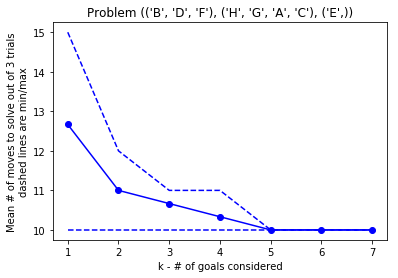

In [159]:
# TODO need to look at problem_record
problem_record_nested = {}
for (problem, k), solves in problem_record.items():
    problem_record_nested.setdefault(problem, {})[k] = solves

# oo multi drops (('C', 'F', 'A'), ('E',), ('D', 'G'), ('H', 'B'))
# snakey? (('D', 'G', 'E', 'C'), ('B', 'F'), ('H', 'A'))
# interesting (and large) variance (('G', 'B', 'F', 'C'), ('A',), ('E', 'H', 'D'))
print(f'in total, have {len(problem_record_nested)} problems')

problem = random.choice(list(problem_record_nested.keys()))
print(problem)
problem = (('G', 'D', 'C'), ('F', 'B'), (), ('E', 'A'))


problem_k_to_length = problem_record_nested[problem]
ks = range(1, max(problem_k_to_length.keys())+1)
plt.figure()
plt.title('Problem {}'.format(initial))
plt.xlabel('k - # of goals considered')
plt.ylabel(f'Mean # of moves to solve out of {len(problem_k_to_length[1])} trials\ndashed lines are min/max')

color = 'b'
plt.plot(ks, [np.mean(problem_k_to_length[k]) for k in ks], color+'-o')
plt.plot(ks, [np.max(problem_k_to_length[k]) for k in ks], color+'--')
plt.plot(ks, [np.min(problem_k_to_length[k]) for k in ks], color+'--')

# Solve the problem too
#problem = Blockworld(problem, _generate_standard_goals_for_blocks(problem))
#history, solved = solve_using_ordered_goal_subset(problem, k=5, debug=True)

In [62]:
def score_k_differentiability(problem_k_to_length):
    ks = range(1, max(problem_k_to_length.keys())+1)
    num_moves = [problem_k_to_length[k] for k in ks]

    # HACK might be better to get the actual range instead?
    # This may not work for various reasons...
    moves_range = num_moves[0]-num_moves[-1]

    num_drops = sum(1 if num_moves[idx-1] > num_moves[idx] else 0 for idx in range(1, len(num_moves)))

    # We want considering more goals to mean you will be more efficient
    # We also think that it's best for this efficiency to be well-distributed
    # across the different k, so upweight based on that.
    return moves_range + 5 * (num_drops-1)

probs = [
    # interesting probs
    (('C', 'F', 'A'), ('E',), ('D', 'G'), ('H', 'B')),
    (('D', 'G', 'E', 'C'), ('B', 'F'), ('H', 'A')),
    (('G', 'B', 'F', 'C'), ('A',), ('E', 'H', 'D')),
    # not interesting
    # 2 drops, but only 1 overall decrease
    (('C', 'E'), ('B',), ('F', 'A', 'D')),
    # flat line
    (('G', 'E', 'D'), ('C',), ('A', 'F', 'B'))
]

for p in probs:
    print('score', score_k_differentiability(problem_record_nested[p]))

score 12.333333333333334
score 12.0
score 15.0
score 6.0
score -5.0


In [80]:
problems = list(problem_record_nested.keys())
problem_scores = [score_k_differentiability(problem_record_nested[p]) for p in problems]

for pidx in sorted(range(len(problems)), key=lambda pidx: problem_scores[pidx], reverse=True)[:30]:
    p = problems[pidx]
    print(problem_scores[pidx], p)


24.0 (('G', 'F', 'D'), ('E', 'H', 'B', 'A', 'C'), ())
19.0 (('A', 'H', 'G', 'E'), ('C', 'F'), ('D', 'B'))
19.0 (('D', 'C'), ('F', 'G', 'B'), ('E', 'H'), ('A',))
17.666666666666664 (('G', 'D', 'C'), ('F', 'B'), (), ('E', 'A'))
17.333333333333336 (('C', 'G', 'A'), ('E',), ('F', 'B', 'D'), ())
17.0 (('D',), ('E', 'G', 'B', 'C', 'A', 'F'), ())
16.333333333333336 (('D',), ('F', 'E', 'G', 'H', 'B', 'A'), ('C',))
16.333333333333332 (('E', 'B'), ('H', 'A', 'C'), ('F', 'G', 'D'))
16.0 (('F', 'C'), ('E', 'G', 'B', 'A'), ('H', 'D'))
15.0 (('G', 'B', 'F', 'C'), ('A',), ('E', 'H', 'D'))
15.0 (('F', 'B'), ('G',), ('H', 'D', 'E', 'C', 'A'))
15.0 (('C',), ('F', 'E', 'H', 'A', 'D'), ('B', 'G'))
14.333333333333332 (('C', 'G', 'A'), ('E',), ('H', 'B', 'D'), ('F',))
14.0 (('E', 'C'), ('A', 'D'), ('F', 'B', 'G'))
13.666666666666668 (('G',), ('B', 'A'), ('D', 'H', 'F', 'C', 'E'))
13.333333333333334 (('A', 'G', 'E'), ('F', 'D'), ('C',), ('B',))
13.0 (('C',), ('E', 'B', 'A'), ('D', 'G', 'F'))
13.0 (('G', 'A',

In [101]:
# Trying to figure out if state canonicalization helps our perf as branching factor gets large

# initial = (('B',), ('D', 'E'), ('F', 'C', 'G', 'A'))
key, value = list(problem_record.items())[110]

print(key, value)

initial, k = key

letters = sorted([l for ls in initial for l in ls])
goals = []
for top, bottom in reversed(list(zip(letters[:-1], letters[1:]))):
    print('Goal {}: {} on top of {}'.format(len(goals), top, bottom))
    goals.append(Blockworld.make_above_predicate(top, bottom))
goals_with_clearing = [Blockworld.make_is_bottom_of_column_predicate(letters[-1])]+goals

problem = Blockworld(initial, goals_with_clearing)
for _ in range(5):
    history, solved = solve_using_ordered_goal_subset(problem, k=k)
    print(len(history)-1)

def _try_to_solve_this_thing(problem, k):
    results = [
        # returns history, solved
        solve_using_ordered_goal_subset(problem, k=k)
        for _ in range(3)
    ]


#problem = Blockworld(initial, goals_with_clearing)

#%timeit _try_to_solve_this_thing(Blockworld(initial, goals_with_clearing), 6)
#%timeit _try_to_solve_this_thing(Blockworld(initial, goals_with_clearing, canonicalize_states=True), 6)
#%timeit _try_to_solve_this_thing(Blockworld(initial, goals_with_clearing), 7)
#%timeit _try_to_solve_this_thing(Blockworld(initial, goals_with_clearing, canonicalize_states=True), 7)

((('F', 'B', 'C'), ('E', 'D'), ('A',)), 5) [9, 9, 9]
Goal 0: E on top of F
Goal 1: D on top of E
Goal 2: C on top of D
Goal 3: B on top of C
Goal 4: A on top of B
9
9
9
9
9


In [ ]:
# Export to JSON!

import json

output_format = [
    dict(
        initial=initial,
        goal_type='any_column',
        goal=[
            sorted([l for ls in initial for l in ls], reverse=True),
        ] + [[]] * (len(initial)-1)
    )
    for initial in initial_states
]

print(json.dumps(output_format, indent=4))

In [ ]:
# HACK HACK why doesn't bfs terminate on this? Does it terminate with state canonicalization? Count distinct states?

'''
....
....
....
....
....
....
H..B
E.AF
CGDI
'''

### Exploring some suboptimalities

In [ ]:
# Why does this fail for even k=4? # moves in 5 trials [29, 29, 29, 29, 29]
badstate1 = (('E', 'A', 'D'), ('C', 'F'), ('B',))
# or this one fails up to k=3
badstate2 = ((), ('A', 'C', 'F'), ('E', 'D', 'B'))

# In general, this class of issue seems to have to do with not clearing underneath the largest block...
# So, if you're considering k "on top of" goals, then you'll optimize with respect to up to k letters
# away from your current one. Otherwise, you might leave k+1 letters and further underneath. So in general
# 'A' will get stuck underneath an F if we don't explicitly clear F.

print('goals without clearing:')
p = Blockworld(badstate1, goals)
history, solved = solve_using_ordered_goal_subset(p, k=3)
assert not solved
print('not solved')

# So when we add clearing as a goal, this all gets nicely resolved:
print('goals with clearing:')
p = Blockworld(badstate1, goals_with_clearing)
history, solved = solve_using_ordered_goal_subset(p, k=3)
assert solved
print('solved in {} moves'.format(len(history)-1))

In [ ]:
state = (('B', 'A', 'E', 'F'), (), ('C', 'D'))
# How is this optimal with k=1?
# After seeing the below with debug=True, it seems this is optimal because there aren't opportunities to
# achieve bad intermediate states. So for instance, once E is on F on column 2, D and C
# are already in the right order to stack. while we do have to shift A around to get B
# on top, we can't block future moves by doing that. So, this is a case where we can't
# create bad intermediate states.

p = Blockworld(state, goals_with_clearing)

print('optimal', bfs_search(p))

history, solved = solve_using_ordered_goal_subset(p, k=1, debug=False)
print('using k=1', [a for a, s in history if a])

In [133]:
# Why does this sometimes do poorly for k=1?: # moves [29, 7, 7, 7, 29]
state = (('B', 'A', 'E', 'F'), (), ('C', 'D'))

# Answer: This does poorly because we sometimes stack F on top of D, which is a weird thing to do and
# sort of related to the previous cell's long answer. When we add the "clearing" goal (that F is on bottom)
# this is a non-issue.

p = Blockworld(state, goals)

print('optimal', bfs_search(p))

for _ in range(10):
    history, solved = solve_using_ordered_goal_subset(p, k=1, debug=False)
    if not solved:
        print('rendering suboptimal solution')
        for a, s in history:
            print(p.render(s))
        break


optimal []


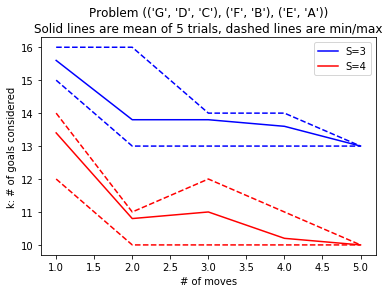

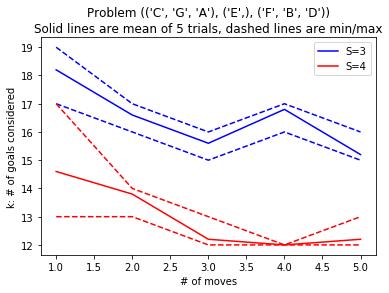

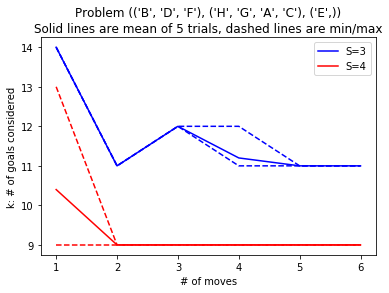

In [153]:
# How important is # spaces for solving our problems?

ps = [
    # tougher ones
    (('G', 'D', 'C'), ('F', 'B'), ('E', 'A')),
    (('C', 'G', 'A'), ('E',), ('F', 'B', 'D')),
    # "easy" ones
    (('B', 'D', 'F'), ('H', 'G', 'A', 'C'), ('E',)),
]

for initial in ps:
    n_trials = 5
    plt.figure()
    letters = _generate_standard_goals_for_blocks(initial, debug=False)
    assert len(initial) == 3
    plt.title('Problem {}\nSolid lines are mean of {} trials, dashed lines are min/max'.format(initial, n_trials))
    plt.xlabel('# of moves')
    plt.ylabel('k: # of goals considered')
    for name, arg, color in [
        ('S=3', initial, 'b'),
        ('S=4', initial+((),), 'r'),
    ]:
        p = Blockworld(arg, letters)
        # HACK Although we normally like to do up to k=# goals, we are only going up to k=# goals - 2 to keep things fast.
        ks = list(range(1, len(p.goals)-1))
        results = [
            [
                len(solve_using_ordered_goal_subset_perf1(p, k=k, debug=False)[0])-1
                for _ in range(n_trials)
            ]
            for k in tqdm(ks)
        ]
        plt.plot(ks, [np.mean(r) for r in results], color, label=name)
        plt.plot(ks, [np.max(r) for r in results], color+'--')
        plt.plot(ks, [np.min(r) for r in results], color+'--')
        plt.legend()
